<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)

# Quickstart with snnTorch
### By Jason K. Eshraghian (www.jasoneshraghian.com)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

In [ ]:
# !pip install snntorch --quiet
# ! pip list | grep snntorch

In [1]:
import torch, torch.nn as nn
import snntorch as snn
import matplotlib.pyplot as plt

In [40]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Net(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.stdp1 = snn.STDPLeaky(
            in_num=inp_num,
            out_num=outp_num,
            beta=0.8,
            decay_pre=0.6,
            decay_post=0.6,
            init_hidden=False,
            reset_mechanism="zero",
            learn_V=False,)

    def forward(self, x):
        spk1, mem1, trace_pre1, trace_post1 = self.stdp1.init_stdpleaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []
        trace_pre_rec = []
        trace_post_rec = []

        for step in range(num_steps):
            spk1, mem1, trace_pre1, trace_post1 = self.stdp1(x[step], spk1, mem1, trace_pre1, trace_post1)
            spk_rec.append(spk1)
            mem_rec.append(mem1)
            trace_pre_rec.append(trace_pre1)
            trace_post_rec.append(trace_post1)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0), torch.stack(trace_pre_rec, dim=0), torch.stack(trace_post_rec, dim=0)

In [44]:
inp_num = 1
num_steps = 50
outp_num = 4
net = Net().to(device)
net.stdp1.V.weight.data = torch.Tensor([[0.2], [0.4], [0.6], [0.8]])
print(net.stdp1.V.weight.data)

tensor([[0.2000],
        [0.4000],
        [0.6000],
        [0.8000]])


In [45]:
inp = torch.randint(low=0, high=2, size=(num_steps, inp_num)).float()
spk_rec, mem_rec, trace_pre_rec, trace_post_rec = net(inp)

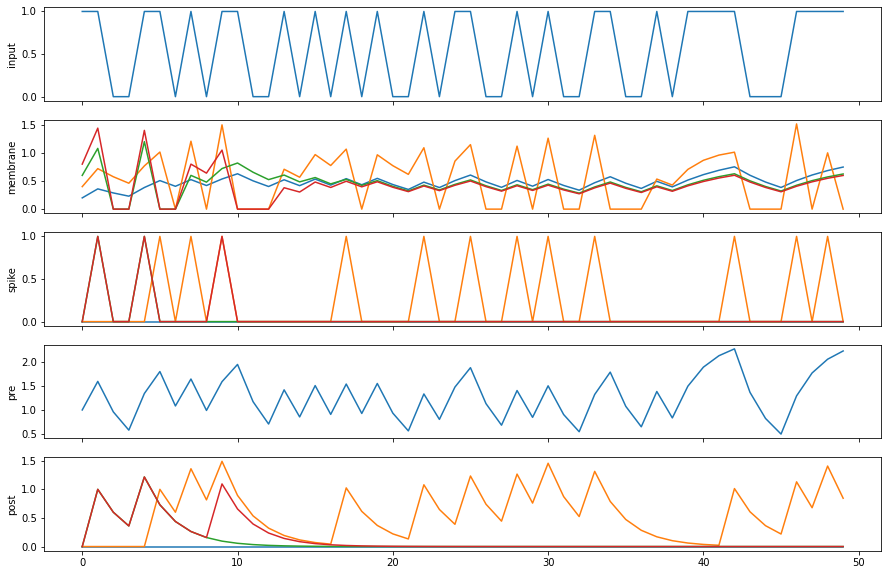

In [46]:
fig, ax = plt.subplots(5, 1, figsize=(15,10),sharex=True)

ax[0].plot(inp.detach().numpy())
ax[0].set_ylabel("input")
ax[1].plot(mem_rec.detach().numpy())
ax[1].set_ylabel("membrane")
ax[2].plot(spk_rec.detach().numpy())
ax[2].set_ylabel("spike")
ax[3].plot(trace_pre_rec.detach().numpy())
ax[3].set_ylabel("pre")
ax[4].plot(trace_post_rec.detach().numpy())
ax[4].set_ylabel("post");
# plt.tight_layout();

## DataLoading
Define variables for dataloading.

In [ ]:
batch_size = 128
data_path='/data/mnist'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Load MNIST dataset.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

## Define Network with snnTorch.
* `snn.Leaky()` instantiates a simple leaky integrate-and-fire neuron.
* `spike_grad` optionally defines the surrogate gradient. If left undefined, the relevant gradient term is simply set to the output spike itself (1/0) by default.


The problem with `nn.Sequential` is that each hidden layer can only pass one tensor to subsequent layers, whereas most spiking neurons return their spikes and hidden state(s). To handle this:

* `init_hidden` initializes the hidden states (e.g., membrane potential) as instance variables to be processed in the background.

The final layer is not bound by this constraint, and can return multiple tensors:
* `output=True` enables the final layer to return the hidden state in addition to the spike.

In [ ]:
from snntorch import surrogate

beta = 0.9  # neuron decay rate
spike_grad = surrogate.fast_sigmoid()

#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 8, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(8, 16, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(16*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

Refer to the snnTorch documentation to see more [neuron types](https://snntorch.readthedocs.io/en/latest/snntorch.html) and [surrogate gradient options](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html).

## Define the Forward Pass
Now define the forward pass over multiple time steps of simulation.

In [ ]:
from snntorch import utils

def forward_pass(net, data, num_steps):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

Define the optimizer and loss function. Here, we use the MSE Count Loss, which counts up the total number of output spikes at the end of the simulation run. The correct class has a target firing rate of 80% of all time steps, and incorrect classes are set to 20%.

In [ ]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Objective functions do not have to be applied to the spike count. They may be applied to the membrane potential (hidden state), or to spike-timing targets instead of rate-based methods. A non-exhaustive list of objective functions available include:

**Apply the objective directly to spikes:**
* MSE Spike Count Loss: `mse_count_loss()`
* Cross Entropy Spike Count Loss: `ce_count_loss()`
* Cross Entropy Spike Rate Loss: `ce_rate_loss()`

**Apply the objective to the hidden state:**
* Cross Entropy Maximum Membrane Potential Loss: `ce_max_membrane_loss()`
* MSE Membrane Potential Loss: `mse_membrane_loss()`

For alternative objective functions, refer to the `snntorch.functional` [documentation here.](https://snntorch.readthedocs.io/en/latest/snntorch.functional.html)

## Training Loop

Now for the training loop. The predicted class will be set to the neuron with the highest firing rate, i.e., a rate-coded output. We will just measure accuracy on the training set. This training loop follows the same syntax as with PyTorch.

In [ ]:
num_epochs = 1
num_steps = 25  # run for 25 time steps

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data, num_steps)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # print every 25 iterations
        if i % 25 == 0:
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")

        # uncomment for faster termination
        # if i == 150:
        #     break


## Automating Backprop

Alternatively, we can automate the backprop through time training process using the `BPTT` method available in `snntorch.backprop`. All model updates take place within the `backprop.BPTT` function call. The specified number of steps in `num_steps` will be simulated just as before.

> The following snippet will take some time to simulate; feel free to reduce the number of epochs.

In [ ]:
from snntorch import backprop

num_epochs = 3

# training loop
for epoch in range(num_epochs):

    avg_loss = backprop.BPTT(net, train_loader, num_steps=num_steps,
                          optimizer=optimizer, criterion=loss_fn, time_var=False, device=device)

    print(f"Epoch {epoch}, Train Loss: {avg_loss.item():.2f}")

Let's see the accuracy on the full test set, again using `SF.accuracy_rate`.

In [ ]:
def test_accuracy(data_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = forward_pass(net, data, num_steps)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
print(f"Test set accuracy: {test_accuracy(test_loader, net, num_steps)*100:.3f}%")

## More control over your model
If you are simulating more complex architectures, such as residual nets, then your best bet is to wrap the network up in a class as shown below. This time, we will explicitly use the membrane potential, `mem`, and let `init_hidden` default to false.

For the sake of speed, we'll just simulate a fully-connected SNN, but this can be generalized to other network types (e.g., Convs).

In addition, let's set the neuron decay rate, `beta`, to be a learnable parameter. The first layer will have a shared decay rate across neurons. Each neuron in the second layer will have an independent decay rate. The decay is clipped between [0,1].

In [ ]:
import torch.nn.functional as F

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 784
        num_hidden = 300
        num_outputs = 10
        spike_grad = surrogate.fast_sigmoid()

        # global decay rate for all leaky neurons in layer 1
        beta1 = 0.9
        # independent decay rate for each leaky neuron in layer 2: [0, 1)
        beta2 = torch.rand((num_outputs), dtype = torch.float) #.to(device)

        # Init layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1, spike_grad=spike_grad, learn_beta=True)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, spike_grad=spike_grad,learn_beta=True)

    def forward(self, x):

        # reset hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Load the network onto CUDA if available
net = Net().to(device)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 1
num_steps = 100  # run for 25 time steps

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net(data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # print every 25 iterations
        if i % 25 == 0:
          net.eval()
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")

        # uncomment for faster termination
        # if i == 150:
        #     break


In [ ]:
print(f"Trained decay rate of the first layer: {net.lif1.beta:.3f}\n")

print(f"Trained decay rates of the second layer: {net.lif2.beta}")

In [ ]:
def test_accuracy(data_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = net(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
print(f"Test set accuracy: {test_accuracy(test_loader, net, num_steps)*100:.3f}%")

# Conclusion
That's it for the quick intro to snnTorch!

* For a detailed tutorial of spiking neurons, neural nets, encoding, and training using neuromorphic datasets, check out the
[snnTorch tutorial series](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).
* For more information on the features of snnTorch, check out the [documentation at this link](https://snntorch.readthedocs.io/en/latest/).
* If you have ideas, suggestions or would like to find ways to get involved, then [check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)